## Grouping students based on marksheets using K Means Clustering

In [174]:
# import all the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# random.seed(42)

In [175]:
# obtain the raw csv 
data = "../assets/data/student_marksheet.csv"
marksheet_df = pd.read_csv(data)

In [176]:
print(marksheet_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       250 non-null    int64 
 1   Name     250 non-null    object
 2   Gender   250 non-null    object
 3   Age      250 non-null    int64 
 4   Section  250 non-null    object
 5   Science  250 non-null    int64 
 6   English  250 non-null    int64 
 7   History  250 non-null    int64 
 8   Maths    250 non-null    int64 
dtypes: int64(6), object(3)
memory usage: 17.7+ KB
None


In [177]:
print(marksheet_df.head())

# Creating a copy for printing results
marksheet_df_copy = marksheet_df.copy()

   id     Name  Gender  Age Section  Science  English  History  Maths
0   1  Bronnie  Female   13       C       21       81       62     49
1   2   Lemmie    Male   15       B       29       41       17     40
2   3    Danya  Female   14       C       12       87       16     96
3   4    Denna  Female   14       B       15       53       82     33
4   5  Jocelin    Male   14       A       43        6        3     21


In [178]:
# Identifying categorical features
print(marksheet_df["Gender"].unique())
print(marksheet_df["Section"].unique())
print(marksheet_df["Age"].unique())

['Female' 'Male']
['C' 'B' 'A']
[13 15 14]


In [179]:
# Converting categorical data to numeric data
marksheet_df["Gender"].replace({"Female": 0, "Male": 1}, inplace=True)
marksheet_df["Section"].replace({"A": 0, "B": 1, "C": 2}, inplace=True)
marksheet_df["Age"].replace({13: 0, 14: 0.5, 15: 1}, inplace=True)

In [180]:
# Dropping name and id column because it will not be used for clustering
marksheet_df.drop(["Name"], axis=1, inplace=True)
marksheet_df.drop(["id"], axis=1, inplace=True)

In [181]:
print(marksheet_df.shape)
print(marksheet_df.head())

(250, 7)
   Gender  Age  Section  Science  English  History  Maths
0       0  0.0        2       21       81       62     49
1       1  1.0        1       29       41       17     40
2       0  0.5        2       12       87       16     96
3       0  0.5        1       15       53       82     33
4       1  0.5        0       43        6        3     21


In [182]:
X_mean = marksheet_df.mean(axis=0, numeric_only=True)
X_std = marksheet_df.std(axis=0, numeric_only=True)

# Normalizing the data
marksheet_df = (marksheet_df - X_mean) / X_std

print(marksheet_df.head())

     Gender       Age   Section   Science   English   History     Maths
0 -1.055542 -1.238469  1.146226 -1.038394  1.102541  0.362059 -0.146642
1  0.943591  1.189901 -0.062873 -0.765492 -0.233063 -1.312763 -0.475272
2 -1.055542 -0.024284  1.146226 -1.345409  1.302881 -1.349981  1.569537
3 -1.055542 -0.024284 -0.062873 -1.243071  0.167618  1.106425 -0.730873
4  0.943591 -0.024284 -1.271972 -0.287912 -1.401716 -1.833819 -1.169047


In [183]:
# Calculates the distance between two data points based on gender, age, section, and marks.
def get_distance(x, y):
    dist = 0

    # Difference in Gender and Section
    if (x[0] != y[0]):
        dist += 5
    if (x[2] != y[2]):
        dist += 5

    # Difference between age
    dist += 2.5*np.abs(x[1] - y[1])

    # Difference between marks in Science, English, History and Maths
    dist += 10*np.abs(x[3] - y[3])
    dist += 10*np.abs(x[4] - y[4])
    dist += 10*np.abs(x[5] - y[5])
    dist += 10*np.abs(x[6] - y[6])

    return dist

# The distance function can be modified by either commenting out the features not required or by modifying weights

In [184]:
# Initializes centroids for K-means clustering using random data points from the dataset.
def init_centroids(K, marksheet_df):
    centroids = set()

    while(len(centroids) != K):
        random_index = random.randint(0, len(marksheet_df)-1)
        z = tuple(marksheet_df.iloc[random_index, -7:])
        centroids.add(z)

    # Convert the set to a list
    centroids = list(centroids)

    return centroids

In [185]:
# Clusters are assigned with the prior knowledge of centroids
def assign_clusters(K, centroids, marksheet_df):
    clusters = [[] for _ in range(K)]
    
    # Assign each data point to its closest centroid
    for i in range(len(marksheet_df)):
        min_dist = float("inf")
        idx = 0
        
        for j in range(len(centroids)):
            dist = get_distance(centroids[j], marksheet_df.loc[i])
            if dist < min_dist:
                min_dist = dist
                idx = j

        clusters[idx].append(i)  # Append index of data point
    
    return clusters

In [186]:
# Centroids of each cluster are updated with the prior knowledge of clusters
def update_centroids(K, clusters):
    centroids = []
    for i in range(K):
        sum = 0
        for j in range(len(clusters[i])):
            sum += np.array(marksheet_df.iloc[clusters[i][j]])
        
        if (len(clusters[i]) == 0):
            sum = 0
            print(f'Warning: Reduce K')
        else:
            sum /= len(clusters[i])

        centroids.append(sum)
    
    return centroids

In [187]:
# Calculates the total dissimilarity of the clusters from their centroids.
def get_dissimilarity(clusters, centroids, marksheet_df):
    dissimilarity = 0
    for i in range(len(clusters)):
        cluster_variance = 0
        for j in range(len(clusters[i])):
            cluster_variance += get_distance(marksheet_df.loc[clusters[i][j]], centroids[i])

        dissimilarity += cluster_variance

    return dissimilarity


In [188]:
# Fits a K-means clustering model to the given dataset.
def fit(K, marksheet_df, num_iterations=100, res=False):
    # Initialize the centroids
    centroids = init_centroids(K, marksheet_df)
    total_dissimilarity = []
    clusters = [[] for _ in range(K)]
    prev_clusters = [[] for _ in range(K)]

    for m in range(num_iterations):
        # Clusters are assigned with the prior knowledge of centroids
        clusters = assign_clusters(K, centroids, marksheet_df)

        # Centroids of each cluster are updated with the prior knowledge of clusters
        centroids = update_centroids(K, clusters)

        # Get dissimilarity score
        dissimilarity_score = get_dissimilarity(clusters, centroids, marksheet_df)
        total_dissimilarity.append(dissimilarity_score)

        if (m % 10 == 0 and res):
            print(f'Completed iteration: {m} with dissimilarity score: {dissimilarity_score}')
        
        if (prev_clusters == clusters):
            if (res):
                print(f'Algorithm Converged at iteration {m} with dissimilarity score: {dissimilarity_score}')
            break

        prev_clusters = clusters

    return clusters, centroids, total_dissimilarity

In [192]:
# Selecting the best result among M random initializations
K = 25
M = 50

best_cluster = [[] for _ in range(K)]
best_centroids = [[] for _ in range(K)]
best_total_dissimilarity = [float("inf")]

for iter in range(M):
    clusters, centroids, total_dissimilarity = fit(K, marksheet_df)

    if (best_total_dissimilarity[-1] > total_dissimilarity[-1]):
        best_total_dissimilarity = total_dissimilarity
        best_centroids = centroids
        best_cluster = clusters
    
    if ((iter+1) % 10 == 0):
        print(f'Completed initialization iteration: {iter+1}')

print(f'Best dissimilarity score: {best_total_dissimilarity[-1]}')

# If the code stops running after giving warning for reducing K, that might be either due to a bad random initialization or a high value of K. Either run the cell again or reduce the value of K.

Completed initialization iteration: 10
Completed initialization iteration: 20
Completed initialization iteration: 30
Completed initialization iteration: 40
Completed initialization iteration: 50
Best dissimilarity score: 6282.818957708942


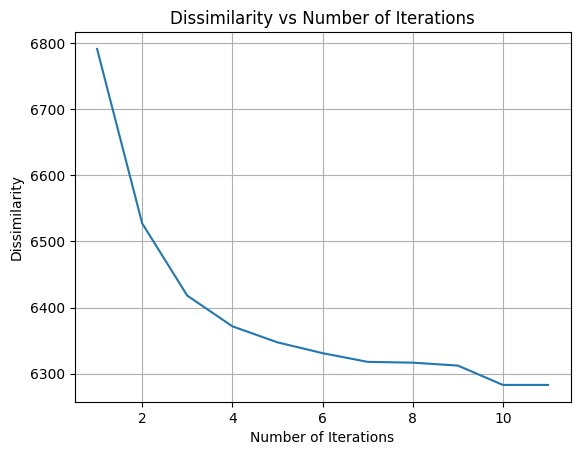

In [193]:
# Plotting missclassifications against the number of iterations
plt.plot(range(1, len(best_total_dissimilarity) + 1), best_total_dissimilarity)
plt.xlabel('Number of Iterations')
plt.ylabel('Dissimilarity')
plt.title('Dissimilarity vs Number of Iterations')
plt.grid(True)
plt.show()

In [194]:
# # Print all groups
# for i in range(len(clusters)):
#     print(f'Group {i}: ')
#     for j in range(len(clusters[i])):
#         print(np.array(marksheet_df_copy.loc[clusters[i][j]]))
#     print(f'Centroid: {np.array(centroids[i] * X_std + X_mean).round(1)}')
#     print("")

# Print specific groups
groups = [0, 9]

for i in groups:
    print(f'Group {i}: ')
    for j in range(len(clusters[i])):
        print(np.array(marksheet_df_copy.loc[clusters[i][j]]))
    print(f'Centroid: {np.array(centroids[i] * X_std + X_mean).round(1)}')
    print("")

Group 0: 
[12 'Valaria' 'Male' 13 'B' 19 5 78 76]
[29 'Adrian' 'Male' 13 'C' 19 8 76 75]
[51 'Skipp' 'Male' 14 'C' 31 37 77 79]
[68 'Drusi' 'Male' 15 'C' 39 7 100 70]
[77 'David' 'Female' 13 'B' 27 2 63 100]
[80 'Elton' 'Male' 13 'B' 13 18 80 82]
[143 'Cristian' 'Male' 13 'B' 5 3 97 84]
[155 'Emlyn' 'Male' 14 'C' 32 3 69 96]
[192 'Jayme' 'Male' 13 'B' 39 14 77 53]
[194 'Olivia' 'Female' 13 'B' 48 4 79 76]
[230 'Kent' 'Male' 15 'C' 15 26 83 75]
[235 'Fleming' 'Male' 13 'C' 31 9 79 54]
[247 'Rog' 'Female' 13 'B' 1 4 68 65]
Centroid: [ 0.8  0.2  1.5 24.5 10.8 78.9 75.8]

Group 9: 
[42 'Hetty' 'Female' 13 'B' 21 89 72 84]
[81 'Teresita' 'Male' 15 'A' 1 90 42 94]
[88 'Sheffie' 'Female' 15 'C' 44 55 51 100]
[98 'Silvia' 'Male' 14 'A' 40 61 63 80]
[129 'Susy' 'Female' 15 'B' 28 94 61 72]
[132 'Tymothy' 'Male' 13 'C' 13 73 76 95]
[147 'Jaquenette' 'Male' 15 'C' 33 75 98 84]
[149 'Adrianne' 'Female' 15 'C' 51 67 67 91]
[152 'Candide' 'Female' 15 'A' 26 76 56 75]
[171 'Fran' 'Female' 15 'B' 34 7